In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from tqdm import tqdm
from sklearn.metrics import r2_score, root_mean_squared_error
from torch.utils.data import Dataset, TensorDataset, DataLoader

from models.fno import FNO
from models.losses import LpLoss, H1Loss

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
data_dir = 'data/2024-08-06'

# Read input function
ax_train_path = os.path.join(data_dir, 'ax_train.pt')
ax_test_path = os.path.join(data_dir, 'ax_test.pt')

ax_train = torch.load(ax_train_path)
ax_test = torch.load(ax_test_path)


# Read target function
ux_train_path = os.path.join(data_dir, 'ux_train.pt')
ux_test_path = os.path.join(data_dir, 'ux_test.pt')

ux_train = torch.load(ux_train_path)
ux_test = torch.load(ux_test_path)

In [4]:
def normalise(dataset, key, channel_mean=None, channel_std=None):
    if channel_mean is None:
        arr = dataset[key].permute(1, 0, 2, 3).flatten(1)
        channel_mean = arr.mean(1)
        channel_std = arr.std(1)
    normalised_dataset = ((dataset[key].permute(0, 2, 3, 1) - channel_mean)/channel_std).permute(0, 3, 1, 2)
    return normalised_dataset, channel_mean, channel_std

In [5]:
class DictDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        return {'x': x, 'y': y}
    
    def __len__(self):
        return len(self.data)

In [6]:
def training_loop(model, train_dl, train_loss, optimizer, scheduler, n_epochs=500):

    train_losses = []
    test_losses = []

    for epoch in tqdm(range(n_epochs)):

        avg_loss = 0
        avg_lasso_loss = 0
        model.train()
        train_err = 0.0

        avg_test_loss = 0
        test_err = 0.0

        for idx, sample in enumerate(train_dl):

            for k,v in sample.items():
                if hasattr(v, 'to'):
                    sample[k] = v.to(device)

            optimizer.zero_grad(set_to_none=True)
            out = model(**sample)

            loss = 0.

            if isinstance(out, torch.Tensor):
                loss = train_loss(out.float(), **sample)
            elif isinstance(out, dict):
                loss += train_loss(**out, **sample)

            del out

            loss.backward()

            optimizer.step()
            train_err += loss.item()

            with torch.no_grad():
                avg_loss += loss.item()
            
            for k,v in sample.items():
                if hasattr(v, 'to'):
                    sample[k] = v.to('cpu')

        if (epoch + 1) % 5:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(train_err)
            else:
                scheduler.step()

        train_err /= len(train_dl)
        avg_loss  /= n_epochs


        train_losses.append(avg_loss)
        # test_losses.append(avg_test_loss)

        # print(f'Epoch: {epoch+1} loss: {avg_loss:.4f}  test loss: {avg_test_loss:.4f} lr: {scheduler.get_last_lr()[0]:.4f}, {optimizer.state_dict()["param_groups"][0]["lr"]:.4f}')
        if (epoch + 1) == n_epochs:
            print(f'Epoch: {epoch+1} loss: {avg_loss:.4f} lr: {scheduler.get_last_lr()[0]:.4f}, {optimizer.state_dict()["param_groups"][0]["lr"]:.4f}')
        
                
    return model

In [7]:
def train_model(train_loader, n_modes=(16, 10), in_channels=2, 
                hidden_channels=64, projection_channels=64, n_epochs=200):
    
    # Losses
    l2loss = LpLoss(d=2, p=2)
    h1loss = H1Loss(d=2)

    train_loss = h1loss
    eval_losses={'h1': h1loss, 'l2': l2loss}
    
    # Model configuration
    n_modes = n_modes
    model = FNO(n_modes=n_modes, in_channels=in_channels, 
                hidden_channels=hidden_channels, 
                projection_channels=projection_channels).float()
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=1e-3,
                                weight_decay=1e-4)
    
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    
    model = training_loop(model, train_loader, 
                          train_loss, optimizer, 
                          scheduler, n_epochs=n_epochs)
    
    return model

In [8]:
train_data_dict = {'ax': ax_train, 'ux': ux_train}
test_data_dict = {'ax': ax_test, 'ux': ux_test}

In [9]:
# Normalize train tensor
ax_train_normalized, ax_channel_mean, ax_channel_std = normalise(train_data_dict, 'ax')
ux_train_normalized, ux_channel_mean, ux_channel_std = normalise(train_data_dict, 'ux')

# Normalize test tensor
ax_test_normalized, _, _ = normalise(test_data_dict, 'ax', ax_channel_mean, ax_channel_std)
ux_test_normalized, _, _ = normalise(test_data_dict, 'ux', ux_channel_mean, ux_channel_std)

In [10]:
train_ds = DictDataset(ax_train_normalized, ux_train_normalized)
test_ds = DictDataset(ax_test_normalized, ux_test_normalized)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)

In [11]:
model = train_model(train_dl, in_channels=2, n_modes=(8, 8),
                    projection_channels=16, n_epochs=200)

  2%|▎         | 5/200 [00:58<37:48, 11.64s/it]


KeyboardInterrupt: 

In [ ]:
res_list = []
for k in range(n_dataset)[:1]:
    train_dataset = {}
    train_dataset['ax'] = torch.concat([datasets[i]['ax'] for i in range(n_dataset) if i!=k], dim=0)
    train_dataset['ux'] = torch.concat([datasets[i]['ux'] for i in range(n_dataset) if i!=k], dim=0)
    val_dataset = datasets[k]

    # Normalise
    train_dataset['ax'], ax_channel_mean, ax_channel_std = normalise(train_dataset, 'ax')
    train_dataset['ux'], ux_channel_mean, ux_channel_std = normalise(train_dataset, 'ux')

    val_dataset['ax'], _, _ = normalise(val_dataset, 'ax', ax_channel_mean, ax_channel_std)
    val_dataset['ux'], _, _ = normalise(val_dataset, 'ux', ux_channel_mean, ux_channel_std)
    
    train_ds = DictDataset(train_dataset['ax'], train_dataset['ux'])
    
    model = train_model(train_dl, in_channels=4, n_modes=(8, 8), n_epochs=1000)
    
    h1_error, r2_error, rmse = validate(model, val_dataset, 
                                        directory=directories[k], 
                                        ux_mean=ux_channel_mean,
                                        ux_std=ux_channel_std,
                                        interpolate=True)
    h1_error, r2_error_noint, rmse_noint = validate(model, val_dataset, 
                                                    directory=f'{directories[k]}_noint', 
                                                    ux_mean=ux_channel_mean,
                                                    ux_std=ux_channel_std,
                                                    interpolate=False)

    μ, σ = list(map(float, directories[k].split('_')))
    
    res = {'$\mu$': μ,
           '$\sigma$': σ,
           'h1_error': h1_error,
           'r2_int': r2_error,
           'r2_noint': r2_error_noint,
           'rmse_int': rmse,
           'rmse_noint': rmse_noint}
    
    res_list.append(res)
    break

In [ ]:
def plot_results(ax, ux, ux_hat, filepath):

    # Extents
    xmin, xmax = ax[0, 0].min(), ax[0].max()
    ymin, ymax = ax[1, :, 0].min(), ax[1, :, 0].max()

    fig, axes = plt.subplots(1, 4, figsize=(18, 3))
    
    im = axes[0].imshow(ax[2], extent=(xmin, xmax, ymin, ymax), origin='lower')
    axes[0].set_title('$h(x)$')
    fig.colorbar(im, orientation='vertical')
    
    
    im = axes[1].imshow(ax[3], extent=(xmin, xmax, ymin, ymax), origin='lower')
    axes[1].set_title('$p(x)$')
    fig.colorbar(im, orientation='vertical')
    
    im = axes[2].imshow(ux[0], extent=(xmin, xmax, ymin, ymax), origin='lower')
    axes[2].set_title('$\phi(x)$')
    fig.colorbar(im, orientation='vertical')
    
    im = axes[3].imshow(ux_hat[0], vmax=ux.max(), vmin=ux.min(), 
                        extent=(xmin, xmax, ymin, ymax), origin='lower')
    axes[3].set_title('$\phi_{pred}(x)$')
    fig.colorbar(im, orientation='vertical')

    # fig.savefig(filepath, bbox_inches='tight')

    return fig

In [ ]:
def validate(model, val_dataset, directory, ux_mean, ux_std, interpolate=True):
    val_ax = val_dataset['ax']
    val_ux = val_dataset['ux']
    
    l2loss = LpLoss(d=2, p=2)
    h1loss = H1Loss(d=2)
    
    with torch.no_grad():
        ϕx_hat = model(val_ax.to(device))
        error = h1loss(ϕx_hat, val_ux.to(device))
        print(f"Validation H1Loss: {error.item():.2f}")
    
    n, c, l, b = ϕx_hat.shape
    n_root = int(np.sqrt(n))
    ϕx_hat = ϕx_hat.reshape((n_root, n_root, c, l, b))

    if interpolate:
        for i in range(2, n_root-1, 2):
            for j in range(2, n_root-1, 2):
                ϕx_hat[i, j, :, :, :b//2] = (ϕx_hat[i, j, :, :, :b//2] + ϕx_hat[i, j-1, :, :, b//2:])/2
                ϕx_hat[i, j, :, :, b//2:] = (ϕx_hat[i, j, :, :, b//2:] + ϕx_hat[i, j+1, :, :, :b//2])/2
                ϕx_hat[i, j, :, :l//2, :] = (ϕx_hat[i, j, :, :l//2, :] + ϕx_hat[i-1, j, :, l//2:, :])/2
                ϕx_hat[i, j, :, l//2:, :] = (ϕx_hat[i, j, :, l//2:, :] + ϕx_hat[i+1, j, :, :l//2, :])/2
            

    # skip alternate rows and cols
    ϕx_hat = ϕx_hat[::2, ::2].cpu().numpy()
    val_ax = val_ax.reshape((n_root, n_root, 4, l, b))[::2, ::2].numpy()
    val_ux = val_ux.reshape((n_root, n_root, 1, l, b))[::2, ::2].numpy()

    ux_unscaled = val_ux.flatten() * ux_std.numpy()[0] + ux_mean.numpy()[0]
    ux_hat_unscaled = ϕx_hat.flatten() * ux_std.numpy()[0] + ux_mean.numpy()[0]

    r2_error = r2_score(ux_unscaled, ux_hat_unscaled)
    rmse = root_mean_squared_error(ux_unscaled, ux_hat_unscaled)

    # ux_hat
    ϕx_hat = np.concatenate([ϕx_hat[:, i] for i in range(n_root//2)], axis=-1)
    ϕx_hat = np.concatenate([ϕx_hat[i] for i in range(n_root//2)], axis=-2)
    
    # ax
    val_ax = np.concatenate([val_ax[:, i] for i in range(n_root//2)], axis=-1)
    val_ax = np.concatenate([val_ax[i] for i in range(n_root//2)], axis=-2)
    
    # ux
    val_ux = np.concatenate([val_ux[:, i] for i in range(n_root//2)], axis=-1)
    val_ux = np.concatenate([val_ux[i] for i in range(n_root//2)], axis=-2)

    # plot results
    plot_results(val_ax, val_ux, ϕx_hat, filepath=f'plots/{directory}.png')
    
    return error.item(), r2_error, rmse

100%|██████████| 1000/1000 [08:09<00:00,  2.04it/s]

Epoch: 1000 loss: 0.0157 lr: 0.0000, 0.0000
Validation H1Loss: 92.63
Validation H1Loss: 92.63


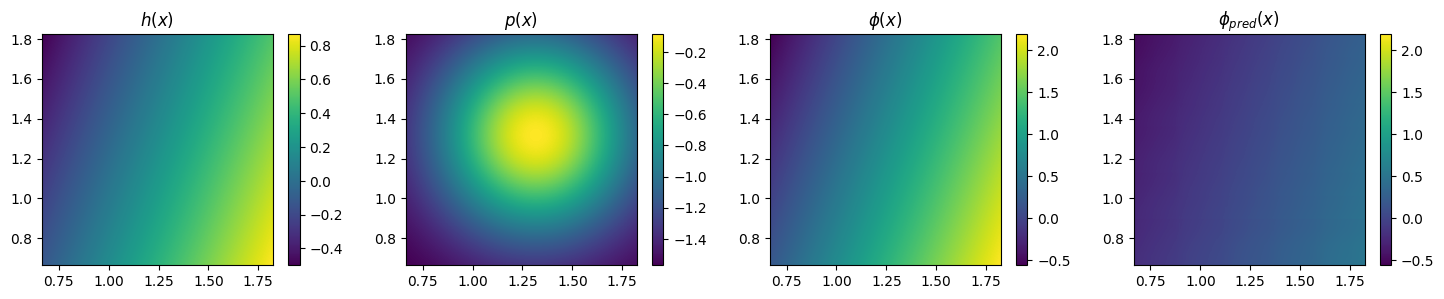

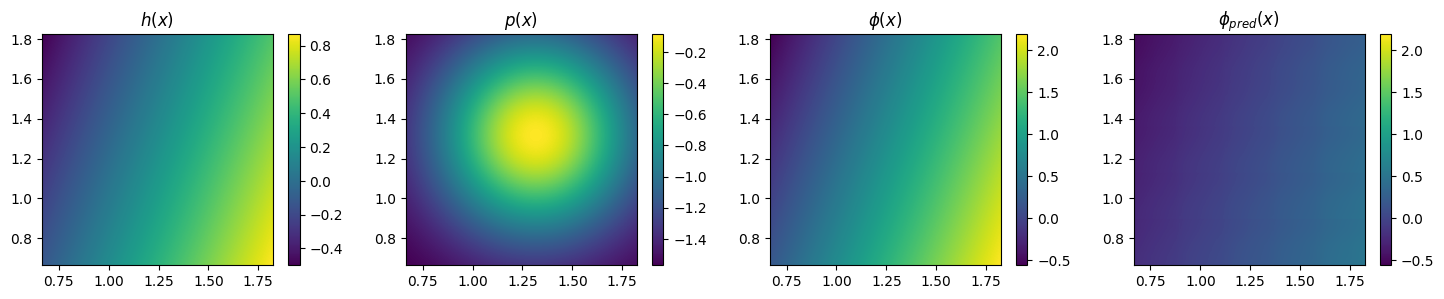

In [ ]:
res

{'$\\mu$': 17.84,
 '$\\sigma$': 4.45,
 'h1_error': 92.63249360575759,
 'r2_int': -0.9939457294735554,
 'r2_noint': -0.9940247693201798,
 'rmse_int': np.float64(208.36045698299816),
 'rmse_noint': np.float64(208.36458663786215)}

In [ ]:
res_df = pd.DataFrame(res_list)
res_df.to_csv('results.csv', index=False)